In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_recall_curve
from imblearn.over_sampling import SMOTE



Fonte dos dados: https://www.kaggle.com/datasets/ealaxi/paysim1/data <br><br>
**Observação importante: Transações que forem detectadas como fraude serão canceladas, portanto para detecção de fraudes as colunas oldbalanceOrig, newbalanceOrg, oldbalanceDest e newbalanceDest não devem ser utilizadas no treinamento do modelo.**<br><br>
Créditos: E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016

##Ingestão dos dados

In [3]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df = df.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'],axis=1)
df.head()

,step,type,amount,nameOrig,nameDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,M1979787155,0,0
1,1,PAYMENT,1864.28,C1666544295,M2044282225,0,0
2,1,TRANSFER,181.00,C1305486145,C553264065,1,0
3,1,CASH_OUT,181.00,C840083671,C38997010,1,0
4,1,PAYMENT,11668.14,C2048537720,M1230701703,0,0


## Análise de dados

In [4]:
print(df['nameOrig'].nunique())
print(df['nameOrig'].size)

6353307
6362620


#### Distribuição das fraudes para cada categoria de transação

In [5]:
fraud_types = df.groupby('type')['isFraud'].sum().reset_index()

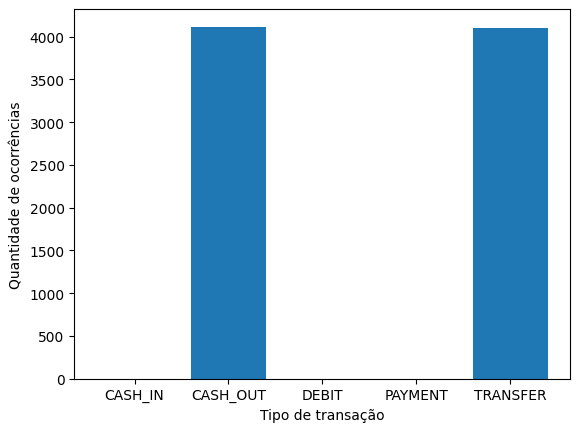

In [6]:
plt.bar(fraud_types['type'],fraud_types['isFraud'])
plt.xlabel('Tipo de transação')
plt.ylabel('Quantidade de ocorrências')
plt.show()

#### Diferença entre o que o sistema aponta como fraude e o que realmente é

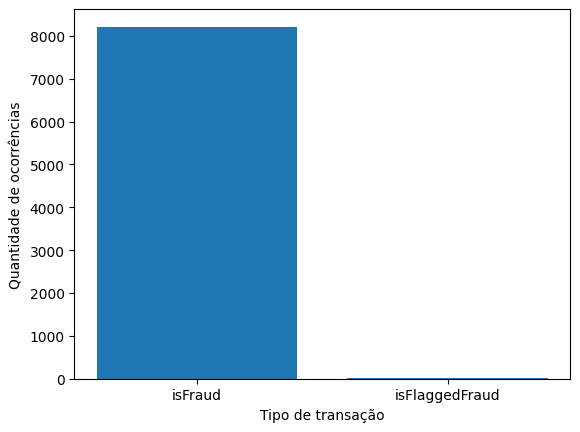

In [7]:
fraudes = df[df['isFraud'] == 1].shape[0]
flagfraudes = df[df['isFlaggedFraud'] == 1].shape[0]

plt.bar(['isFraud', 'isFlaggedFraud'], [fraudes, flagfraudes])
plt.xlabel('Tipo de transação')
plt.ylabel('Quantidade de ocorrências')
plt.show()

In [8]:
print(fraudes)
print(flagfraudes)

8213
16


In [9]:
print(f"Número de fraudes: {df[df['isFraud'] == 1].shape[0]}")
print(f"Número de transações não fraudulentas: {df[df['isFraud'] == 0].shape[0]}")

Número de fraudes: 8213
Número de transações não fraudulentas: 6354407


##Split treino e teste

 One hot encoding das categorias não numéricas

In [10]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)
df.head(5)

,step,amount,nameOrig,nameDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,M1979787155,0,0,False,False,True,False
1,1,1864.28,C1666544295,M2044282225,0,0,False,False,True,False
2,1,181.00,C1305486145,C553264065,1,0,False,False,False,True
3,1,181.00,C840083671,C38997010,1,0,True,False,False,False
4,1,11668.14,C2048537720,M1230701703,0,0,False,False,True,False


In [11]:
X_df = df.drop(["isFraud",'nameOrig','nameDest'],axis=1)
y_df = df['isFraud']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, stratify=y_df, test_size=0.1)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## Scaling das features


In [13]:
X_train.columns

Index(['step', 'amount', 'isFlaggedFraud', 'type_CASH_OUT', 'type_DEBIT',
       'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')

In [14]:
mm = MinMaxScaler()


In [15]:
tbscolumns = ['step','amount']

X_train[tbscolumns] = mm.fit_transform(X_train[tbscolumns])
X_test[tbscolumns] = mm.transform(X_test[tbscolumns])

In [16]:
X_train.head()

,step,amount,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0.057951,0.000141,0,False,False,True,False
1,0.175202,0.003544,0,True,False,False,False
2,0.467655,0.000684,0,True,False,False,False
3,0.249326,0.003650,0,True,False,False,False
4,0.045822,0.002799,0,True,False,False,False


## Model testing

#### Logistic Regression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [ ]:
accuracy_score(y_test, lr.predict(X_test))

0.9986884333812172

In [ ]:
print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.00      0.00      0.00      1643

    accuracy                           1.00   1272524
   macro avg       0.50      0.50      0.50   1272524
weighted avg       1.00      1.00      1.00   1272524



#### Logistic Regression + Oversampling

In [ ]:
lr2 = LogisticRegression()
lr2.fit(X_train_resampled, y_train_resampled)

LogisticRegression()

In [ ]:
accuracy_score(y_test, lr2.predict(X_test))

0.9987096510556972

In [ ]:
print(classification_report(y_test, lr2.predict(X_test)))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635441
           1       0.00      0.00      0.00       821

    accuracy                           1.00    636262
   macro avg       0.50      0.50      0.50    636262
weighted avg       1.00      1.00      1.00    636262



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### SGD Classifier

In [ ]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)

SGDClassifier()

In [ ]:
accuracy_score(y_test, sgd.predict(X_test))

0.9873605527282786

In [ ]:
print(classification_report(y_test, sgd.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1270881
           1       0.01      0.05      0.01      1643

    accuracy                           0.99   1272524
   macro avg       0.50      0.52      0.50   1272524
weighted avg       1.00      0.99      0.99   1272524



#### SGD Classifier + oversampling

In [ ]:
sgd2 = SGDClassifier()
sgd2.fit(X_train_resampled, y_train_resampled)

SGDClassifier()

In [ ]:
accuracy_score(y_test, sgd2.predict(X_test))

0.9987096510556972

In [ ]:
print(classification_report(y_test, sgd2.predict(X_test)))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635441
           1       0.00      0.00      0.00       821

    accuracy                           1.00    636262
   macro avg       0.50      0.50      0.50    636262
weighted avg       1.00      1.00      1.00    636262



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Decision Tree

In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
accuracy_score(y_test, dtc.predict(X_test))

0.9987175094536528

In [ ]:
print(classification_report(y_test, dtc.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635441
           1       0.50      0.49      0.50       821

    accuracy                           1.00    636262
   macro avg       0.75      0.74      0.75    636262
weighted avg       1.00      1.00      1.00    636262



#### Decision Tree + oversampling

In [ ]:
dtc2 = DecisionTreeClassifier()
dtc2.fit(X_train_resampled, y_train_resampled)

In [ ]:
accuracy_score(y_test, dtc2.predict(X_test))

In [ ]:
print(classification_report(y_test, dtc2.predict(X_test)))

#### Random Forest

In [17]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [18]:
accuracy_score(y_test, rfc.predict(X_test))

0.9990507055269684

In [19]:
print(classification_report(y_test, rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635441
           1       0.79      0.36      0.49       821

    accuracy                           1.00    636262
   macro avg       0.89      0.68      0.75    636262
weighted avg       1.00      1.00      1.00    636262



#### Random forest + oversampling

In [20]:
rfc2 = RandomForestClassifier()
rfc2.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier()

In [21]:
accuracy_score(y_test, rfc2.predict(X_test))

0.5664333246367063

In [22]:
print(classification_report(y_test, rfc2.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.57      0.72    635441
           1       0.00      1.00      0.01       821

    accuracy                           0.57    636262
   macro avg       0.50      0.78      0.36    636262
weighted avg       1.00      0.57      0.72    636262



#### GaussianNB

In [23]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [24]:
accuracy_score(y_test, gnb.predict(X_test))

0.34667322580949356

In [25]:
print(classification_report(y_test, gnb.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.35      0.51    635441
           1       0.00      1.00      0.00       821

    accuracy                           0.35    636262
   macro avg       0.50      0.67      0.26    636262
weighted avg       1.00      0.35      0.51    636262



####GaussianNB + oversampling

In [26]:
gnb2 = GaussianNB()
gnb2.fit(X_train_resampled, y_train_resampled)

GaussianNB()

In [27]:
accuracy_score(y_test, gnb2.predict(X_test))

0.9987096510556972

In [28]:
print(classification_report(y_test, gnb2.predict(X_test)))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635441
           1       0.00      0.00      0.00       821

    accuracy                           1.00    636262
   macro avg       0.50      0.50      0.50    636262
weighted avg       1.00      1.00      1.00    636262



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Concluimos que o modo de treinamento que mais trouxe bons resultados foi o modelo Random Forest e sem oversampling, mantendo uma proporção extremamente minoritária das transações fraudulentas no dataset.